# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data load

In [2]:
expression_data = pd.read_csv('../TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)  # Gene expression (TPM)
methylation_data = pd.read_csv('../TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)  # DNA methylation
copy_number_data = pd.read_csv('../TCGA-SARC.gene-level_absolute.tsv', sep='\t', index_col=0) # Copy number variations

try:
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except Exception as e:
    print("Error while loading phenotype_data:", e)
    with open('../TCGA-SARC.clinical.tsv', 'r') as f:
        for i, line in enumerate(f):
            try:
                pd.read_csv(pd.compat.StringIO(line), sep='\t')
            except Exception as row_e:
                print(f"Error in line {i}: {row_e}")
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Data shapes:")
print(f"Expression data: {expression_data.shape}")
print(f"Methylation data: {methylation_data.shape}")
print(f"Copy number data: {copy_number_data.shape}")
print(f"Phenotype data: {phenotype_data.shape}")

Data shapes:
Expression data: (60660, 265)
Methylation data: (486427, 269)
Copy number data: (60623, 248)
Phenotype data: (272, 78)


# Sample Matching

In [3]:
print("Checking for missing values in phenotype data:")
missing_values = phenotype_data.isnull().sum()
print(missing_values[missing_values > 0])

print()
print("Checking sample overlap between different omics data:")

samples_expression = set(expression_data.columns)
samples_methylation = set(methylation_data.columns)
samples_cnv = set(copy_number_data.columns)
samples_clinical = set(phenotype_data.index)
print("Sample overlap:")
print(f"Expression samples: {len(samples_expression)}")
print(f"Methylation samples: {len(samples_methylation)}")
print(f"CNV samples: {len(samples_cnv)}")
print(f"Clinical samples: {len(samples_clinical)}")

# Find common samples across all omics
common_samples = list(samples_expression.intersection(samples_methylation, samples_cnv, samples_clinical))
print(f"Common samples across all omics: {len(common_samples)}")

# Filter data to keep only common samples
expression_data = expression_data[common_samples]
methylation_data = methylation_data[common_samples]
copy_number_data = copy_number_data[common_samples]
phenotype_data = phenotype_data.loc[common_samples]



Checking for missing values in phenotype data:
days_to_birth.demographic                                      1
year_of_birth.demographic                                      4
days_to_death.demographic                                    170
year_of_death.demographic                                    195
entity_submitter_id.annotations                              254
notes.annotations                                            254
submitter_id.annotations                                     254
classification.annotations                                   254
entity_id.annotations                                        254
created_datetime.annotations                                 254
annotation_id.annotations                                    254
entity_type.annotations                                      254
updated_datetime.annotations                                 254
case_id.annotations                                          254
state.annotations                          

# Data preprocessing

### Check Null value

In [4]:
#Check for null values of expression data
print("Checking for null values in expression data:")
null_expression = expression_data.isnull().sum().sum()
if null_expression > 0:
    print(f"Expression data contains {null_expression} null values.")
else:   
    print("No null values found in expression data.")
print()


# Check for null values in methylation data
print("Checking for null values in methylation data:")
null_methylation = methylation_data.isnull().sum().sum()
if null_methylation > 0:
    print(f"Methylation data contains {null_methylation} null values.")
else:
    print("No null values found in methylation data.")
print()


# Check for null values in copy number data
print("Checking for null values in copy number data:")
null_copy_number = copy_number_data.isnull().sum().sum()
if null_copy_number > 0:
    print(f"Copy number data contains {null_copy_number} null values.")
else:
    print("No null values found in copy number data.")
max_value = copy_number_data.max().max()
min_value = copy_number_data.min().min()

print(f"Maximum CNV value: {max_value}")
print(f"Minimum CNV value: {min_value}")
print()


# Check for null values in phenotype data
print("Checking for null values in phenotype data:")
null_phenotype = phenotype_data.isnull().sum().sum()
if null_phenotype > 0:
    print(f"Phenotype data contains {null_phenotype} null values.")
else:
    print("No null values found in phenotype data.")



Checking for null values in expression data:
No null values found in expression data.

Checking for null values in methylation data:
Methylation data contains 19622910 null values.

Checking for null values in copy number data:
Copy number data contains 994360 null values.
Maximum CNV value: 7.0
Minimum CNV value: 0.0

Checking for null values in phenotype data:
Phenotype data contains 3960 null values.
Maximum CNV value: 7.0
Minimum CNV value: 0.0

Checking for null values in phenotype data:
Phenotype data contains 3960 null values.


### Process data

In [5]:
# expression data preprocessing -------------------------------------------------->

# Log2 transform
expression_data_log = np.log2(expression_data + 1)

# Z-score standardization
selector_expr = VarianceThreshold(threshold=0.01)
expression_filtered = pd.DataFrame(
    selector_expr.fit_transform(expression_data_log.T).T,
    index=expression_data_log.index[selector_expr.get_support()],
    columns=expression_data_log.columns
)
expression_data_scaled = expression_filtered.copy()



# Methylation data preprocessing -------------------------------------------------->

# Drop probes with more than 20% missing values
methylation_data = methylation_data.dropna(thresh=0.8* methylation_data.shape[1], axis=0)

# Convert beta values to M-values
epsilon = 1e-6
methylation_beta = methylation_data.clip(epsilon, 1 - epsilon)
methylation_m_values = np.log2(methylation_beta / (1 - methylation_beta))

# Remove low-variance methylation probes
selector = VarianceThreshold(threshold=0.01)
methylation_filtered = pd.DataFrame(
    selector.fit_transform(methylation_m_values.T).T,
    index=methylation_m_values.index[selector.get_support()],
    columns=methylation_m_values.columns
)
methylation_scaled = methylation_filtered.copy()


# Copy number data preprocessing -------------------------------------------------->

# Drop genes with >20% missing values
copy_number_data_filtered = copy_number_data.loc[
    copy_number_data.isnull().mean(axis=1) < 0.2
]
# # Cap values to biologically plausible range
# copy_number_imputed = copy_number_data_filtered
cnv_clipped = copy_number_data_filtered.clip(lower=0.05, upper=6)
log_cnv = np.log2(cnv_clipped / 2)
cnv_selector = VarianceThreshold(threshold=0.01)
copy_number_scaled = pd.DataFrame(
    cnv_selector.fit_transform(log_cnv.T).T,
    index=log_cnv.index[cnv_selector.get_support()],
    columns=log_cnv.columns
)

In [6]:
# Phenotype data preprocessing -------------------------------------------------->
subtype_column = 'primary_diagnosis.diagnoses'
print(f"Using '{subtype_column}' as the subtype column")
print(f"Subtype distribution:\n{phenotype_data[subtype_column].value_counts()}")
print()
# Only keep selected subtypes
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
 ]
phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
print(f"Filtered to selected subtypes. Remaining samples: {len(phenotype_data)}")
# Checking missing values in the subtype column
missing_subtypes = phenotype_data[subtype_column].isnull().sum()
print(f"Missing values in subtype column: {missing_subtypes}")
if missing_subtypes > 0:
    phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])
    print(f"Removed {missing_subtypes} samples with missing subtypes")
    print(f"Remaining samples: {len(phenotype_data_clean)}")
else:
    phenotype_data_clean = phenotype_data.copy()
    print("No missing subtypes found")

Using 'primary_diagnosis.diagnoses' as the subtype column
Subtype distribution:
primary_diagnosis.diagnoses
Leiomyosarcoma, NOS                        96
Dedifferentiated liposarcoma               53
Undifferentiated sarcoma                   34
Fibromyxosarcoma                           22
Malignant fibrous histiocytoma             11
Malignant peripheral nerve sheath tumor    10
Synovial sarcoma, spindle cell              6
Giant cell sarcoma                          3
Myxoid leiomyosarcoma                       2
Synovial sarcoma, biphasic                  2
Pleomorphic liposarcoma                     2
Synovial sarcoma, NOS                       2
Liposarcoma, well differentiated            1
Aggressive fibromatosis                     1
Abdominal fibromatosis                      1
Name: count, dtype: int64

Filtered to selected subtypes. Remaining samples: 205
Missing values in subtype column: 0
No missing subtypes found


### Sample matching

In [7]:
# Extract subtypes for the common samples
subtypes = phenotype_data_clean[subtype_column]
# Encode subtypes as numeric labels
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes)
# Create mapping to encode subtype classes
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nSubtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"  {encoded}: {subtype}")
# Converted to pandas Series to easily handle the index
subtype_encoded = pd.Series(subtype_encoded, index=subtypes.index, name='subtype_encoded')
print(f"\nEncoded subtype distribution:")
print(subtype_encoded.value_counts().sort_index())
# Update common samples with available subtypes
valid_samples = list(set(common_samples).intersection(set(phenotype_data_clean.index)))
print(f"\nUpdating common samples from {len(common_samples)} to {len(valid_samples)} (removed samples with missing subtypes or not in selected subtypes)")
expression_data_scaled = expression_data_scaled[valid_samples]
methylation_scaled = methylation_scaled[valid_samples]
copy_number_scaled = copy_number_scaled[valid_samples]
subtype_encoded = subtype_encoded.loc[valid_samples]
common_samples = valid_samples
print()
print(f"Final data shapes after phenotype preprocessing:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Phenotype: {phenotype_data_clean.shape}")
print(f"  Subtypes: {len(subtype_encoded)}")
print(f"  Common samples: {len(common_samples)}")


Subtype encoding mapping:
  0: Dedifferentiated liposarcoma
  1: Fibromyxosarcoma
  2: Leiomyosarcoma, NOS
  3: Undifferentiated sarcoma

Encoded subtype distribution:
subtype_encoded
0    53
1    22
2    96
3    34
Name: count, dtype: int64

Updating common samples from 246 to 205 (removed samples with missing subtypes or not in selected subtypes)

Final data shapes after phenotype preprocessing:
  Expression: (44663, 205)
  Methylation: (396650, 205)
  Copy number: (56756, 205)
  Phenotype: (205, 78)
  Subtypes: 205
  Common samples: 205

Final data shapes after phenotype preprocessing:
  Expression: (44663, 205)
  Methylation: (396650, 205)
  Copy number: (56756, 205)
  Phenotype: (205, 78)
  Subtypes: 205
  Common samples: 205


In [8]:
# Save processed datasets for reproducibility
# expression_data_scaled.to_csv("../NewDatasets/expression_data_scaled_FXS_MOFA_3Omics.csv", mode="w")
# methylation_scaled.to_csv("../NewDatasets/methylation_scaled_FXS_MOFA_3Omics.csv", mode="w")
# copy_number_scaled.to_csv("../NewDatasets/copy_number_scaled_FXS_MOFA_3Omics.csv", mode="w")
# subtype_encoded.to_csv("../NewDatasets/subtype_encoded_FXS_MOFA_3Omics.csv", mode="w")
# phenotype_data_clean.to_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", mode="w")

In [9]:
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Phenotype:", phenotype_data_clean.shape)
print("Subtype labels:", subtype_encoded.shape)
print("Common samples:", len(common_samples))

Expression: (44663, 205)
Methylation: (396650, 205)
Copy Number: (56756, 205)
Phenotype: (205, 78)
Subtype labels: (205,)
Common samples: 205


In [10]:
print("Missing values before MOFA:")
print(f"Expression: {expression_data_scaled.isnull().sum().sum()}")
print(f"Methylation: {methylation_scaled.isnull().sum().sum()}")  
print(f"Copy number: {copy_number_scaled.isnull().sum().sum()}")

Missing values before MOFA:
Expression: 0
Methylation: 745735
Copy number: 106748


In [11]:
from mofapy2.run.entry_point import entry_point

data_list = [
    [expression_data_scaled.T.values],   # view 0, group 0
    [methylation_scaled.T.values],       # view 1, group 0
    [copy_number_scaled.T.values]       # view 2, group 0
]

# Initialise MOFA
ent = entry_point()
ent.set_data_options(
    scale_views=True,
    scale_groups=False
)
ent.set_data_matrix(data_list)

ent.set_model_options(
    factors=15,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=100,
    convergence_mode="medium",
    seed=42,
    verbose=True,
    gpu_mode=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Scaling views to unit variance...

View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default 

In [12]:
print("Factors shape",factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)
print("Weights shape (view2):", weights[2].shape)


Factors shape (205, 15)
Weights shape (view0): (44663, 15)
Weights shape (view1): (396650, 15)
Weights shape (view2): (56756, 15)


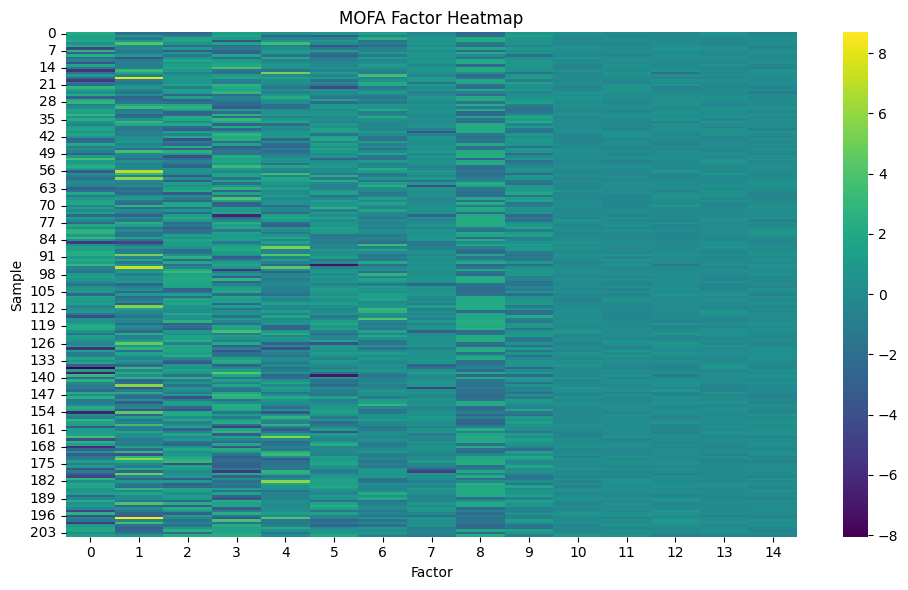

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


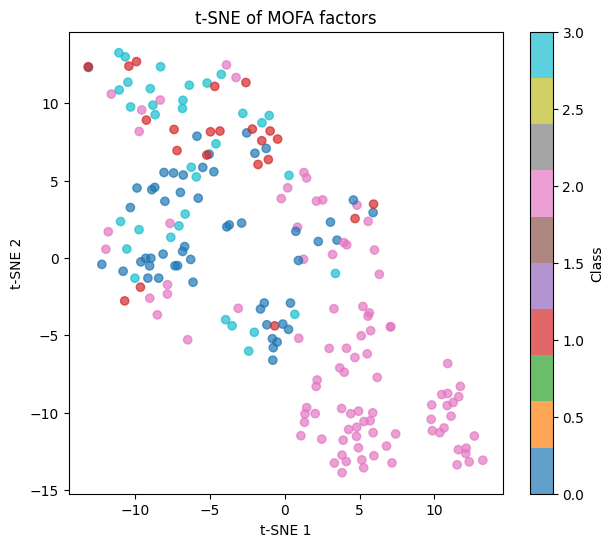

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()


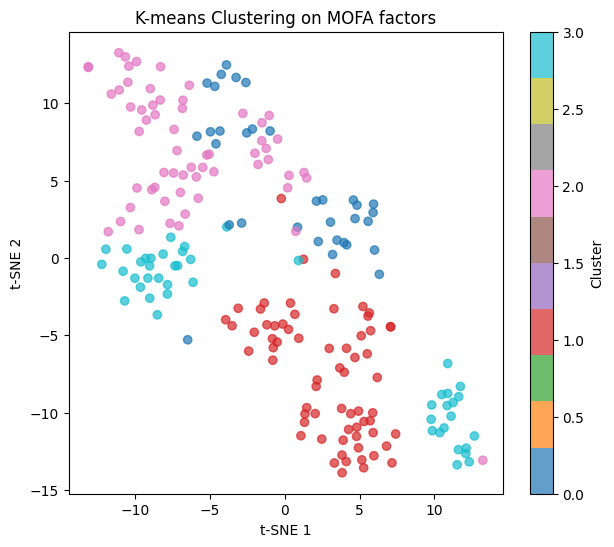

In [15]:
#kmeans clustering on the factors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(factors)
labels = kmeans.labels_
plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K-means Clustering on MOFA factors")
plt.colorbar(label="Cluster")
plt.show()

In [16]:
import numpy as np

# Get factor matrix (samples × factors)
factors = ent.model.nodes["Z"].getExpectation()

# Compute L2 norm of each factor across samples
factor_norms = np.linalg.norm(factors, axis=0)

print("Factor norms:", factor_norms)
active_factors = np.sum(factor_norms > 1e-2)  # threshold can be adjusted
print(f"Active factors: {active_factors} / {factors.shape[1]}")


Factor norms: [32.14258909 32.90017881 27.13909191 31.02122203 24.00372571 20.91263996
 17.59335929 13.78148125 27.97037166 16.68027981  4.20699571  4.42451233
  5.34582296  4.12762467  4.32397579]
Active factors: 15 / 15


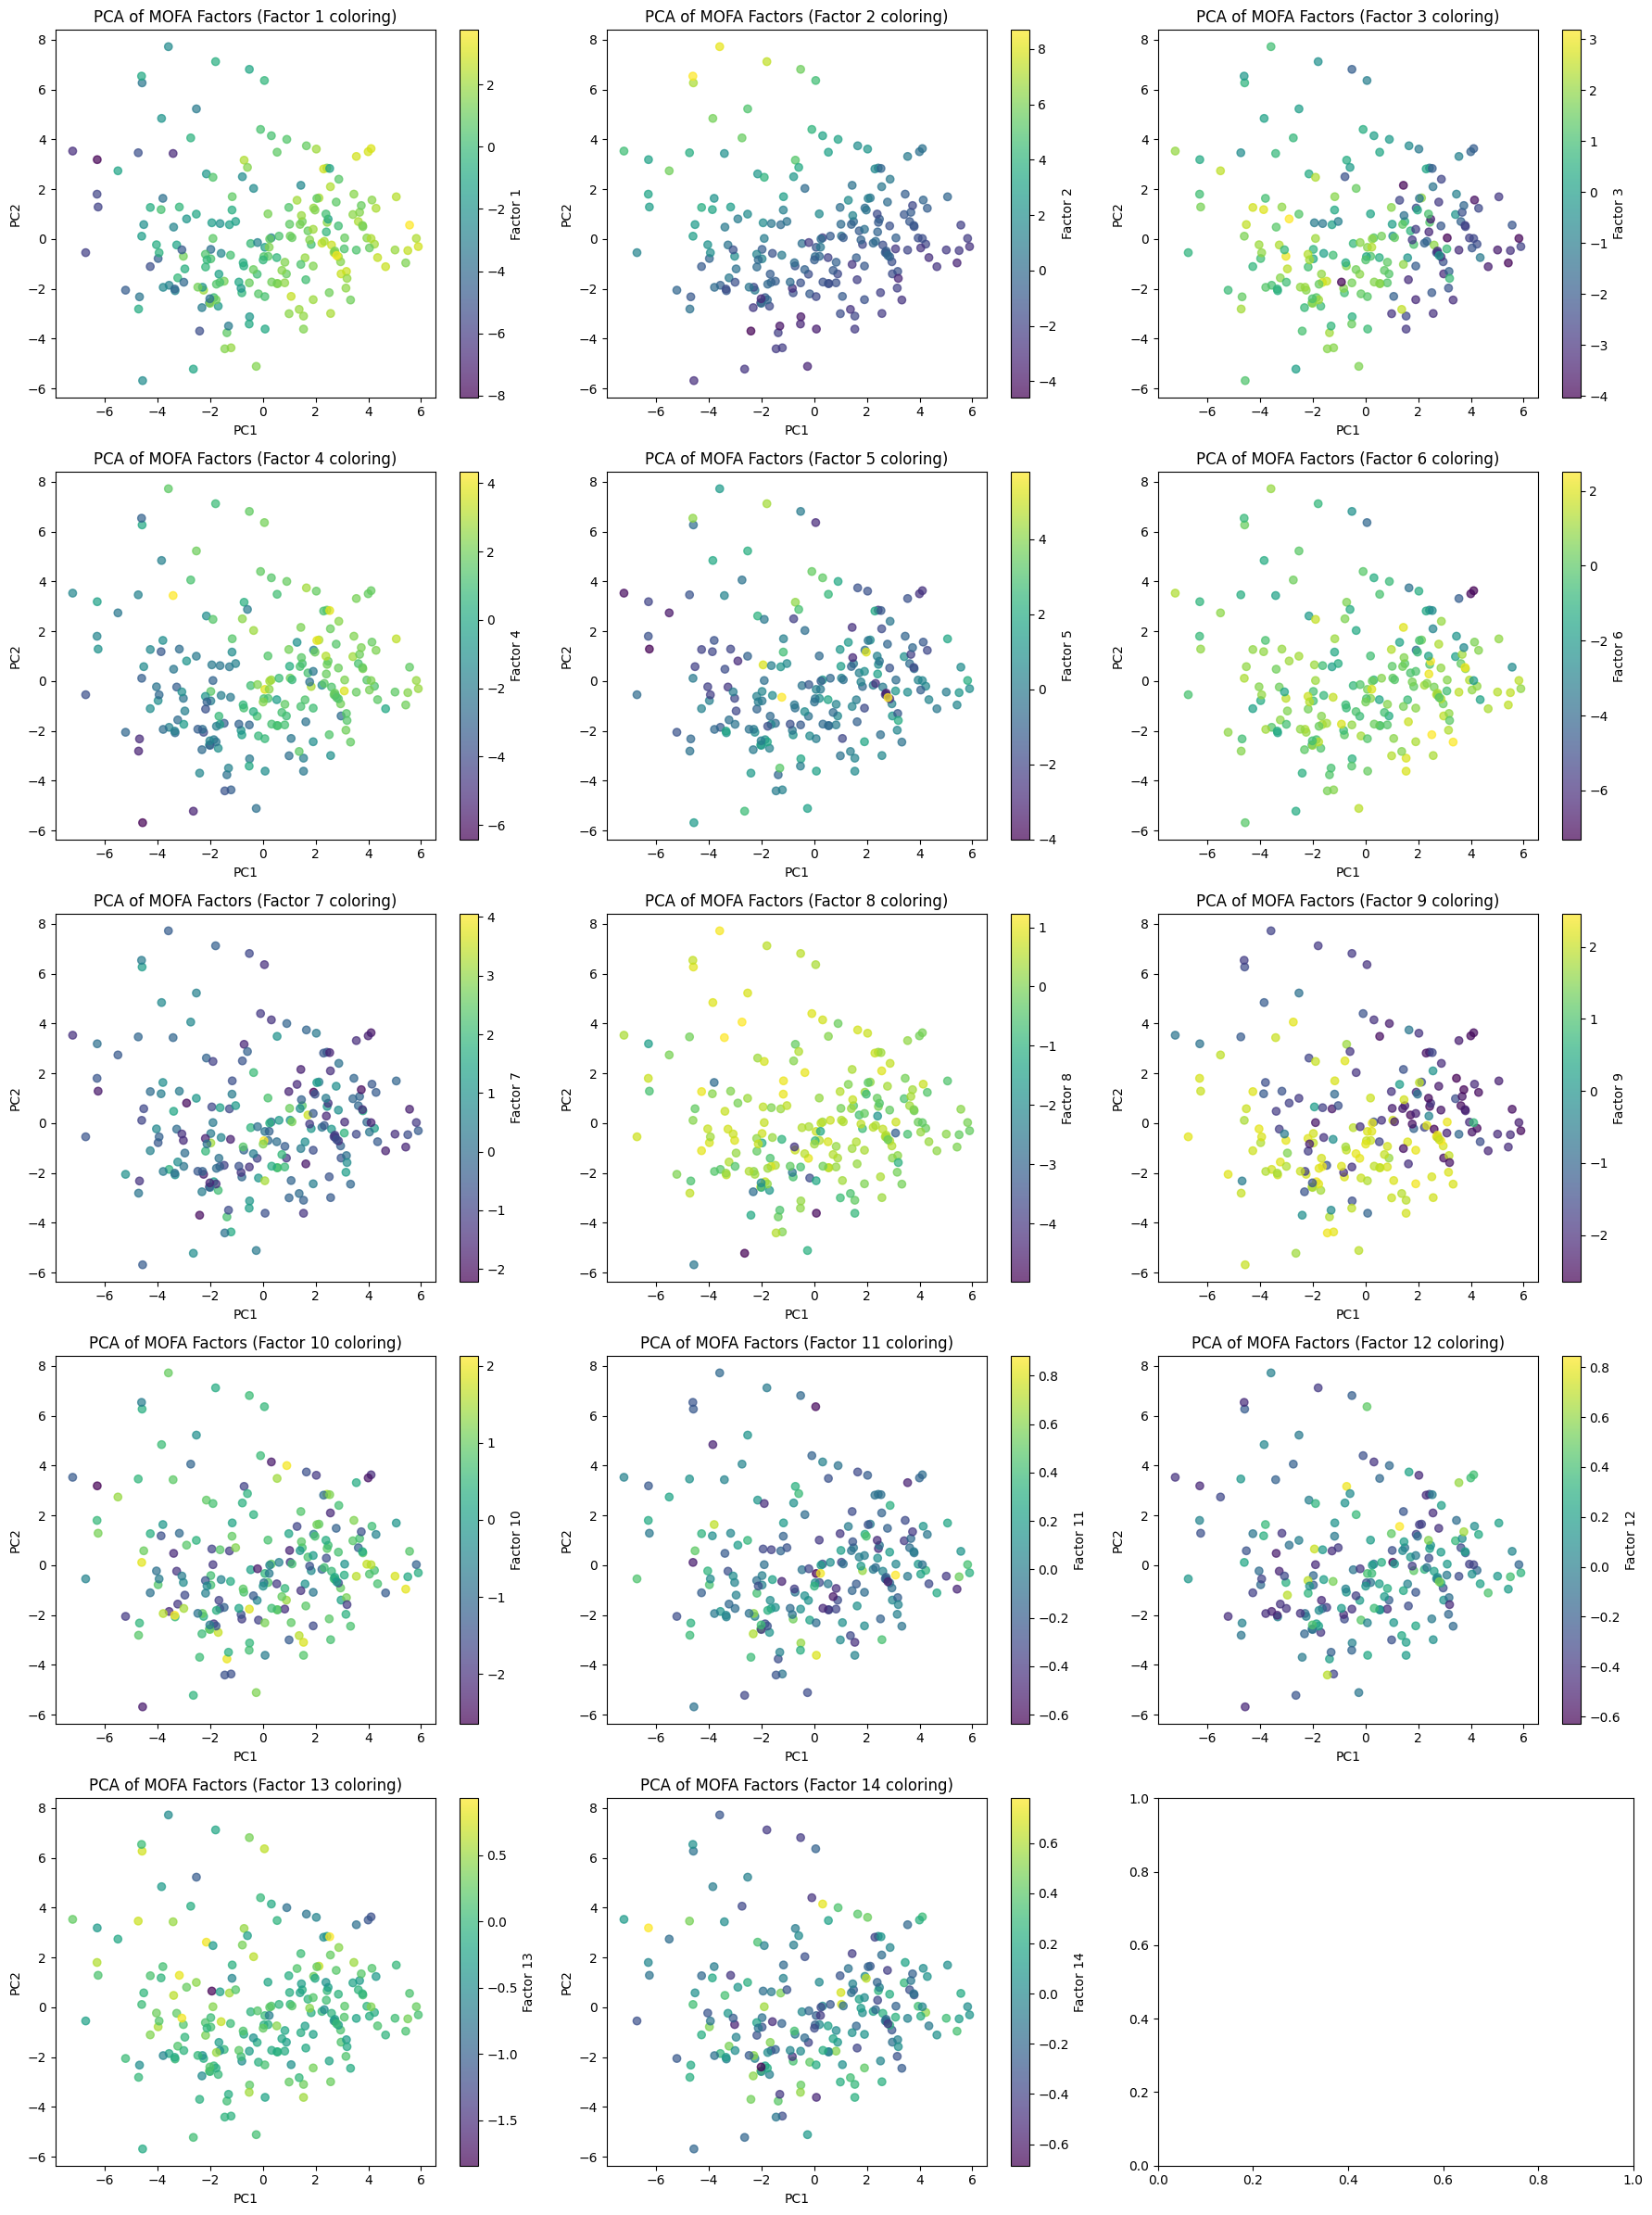

In [17]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(14):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Factors: samples × factors
X = np.array(factors)   # shape (177, 20)

# Labels: subtype-encoded
y = subtype_encoded.loc[common_samples].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

# Predictions and accuracy
preds_lr = clf_lr.predict(X_test)
y_true_lr = y_test
acc_lr = accuracy_score(y_true_lr, preds_lr)
y_pred_proba_lr = clf_lr.predict_proba(X_test)
print('Logistic Regression accuracy:', acc_lr)

Logistic Regression accuracy: 0.7804878048780488


In [19]:
# 2. Random Forest on MOFA factors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict(X_test)
y_true_rf = y_test
acc_rf = accuracy_score(y_true_rf, preds_rf)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
print('Random Forest accuracy:', acc_rf)

Random Forest accuracy: 0.8048780487804879


In [20]:
# 3. Support Vector Machine (SVM) on MOFA factors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm = clf_svm.predict(X_test)
y_true_svm = y_test
acc_svm = accuracy_score(y_true_svm, preds_svm)
y_pred_proba_svm = clf_svm.predict_proba(X_test)
print('SVM accuracy:', acc_svm)

SVM accuracy: 0.8048780487804879


In [21]:
# 4. Gradient Boosting on MOFA factors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
clf_gb.fit(X_train, y_train)
preds_gb = clf_gb.predict(X_test)
y_true_gb = y_test
acc_gb = accuracy_score(y_true_gb, preds_gb)
y_pred_proba_gb = clf_gb.predict_proba(X_test)
print('Gradient Boosting accuracy:', acc_gb)

Gradient Boosting accuracy: 0.7560975609756098


In [22]:
# 5. Naive Bayes on MOFA factors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
preds_nb = clf_nb.predict(X_test)
y_true_nb = y_test
acc_nb = accuracy_score(y_true_nb, preds_nb)
y_pred_proba_nb = clf_nb.predict_proba(X_test)
print('Naive Bayes accuracy:', acc_nb)

Naive Bayes accuracy: 0.7804878048780488


In [23]:
# Compare all 5 classifiers on MOFA factors: accuracy, F1 (macro/micro), precision, recall, C-index
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import column_or_1d
import numpy as np
import pandas as pd

# Function to calculate C-index (concordance index)
def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (concordance index) for multiclass classification
    """
    try:
        from sklearn.metrics import roc_auc_score
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

results = []
results.append(["Logistic Regression", acc_lr, f1_score(y_true_lr, preds_lr, average='macro'), f1_score(y_true_lr, preds_lr, average='micro'), precision_score(y_true_lr, preds_lr, average='macro', zero_division=0), precision_score(y_true_lr, preds_lr, average='micro', zero_division=0), recall_score(y_true_lr, preds_lr, average='macro'), recall_score(y_true_lr, preds_lr, average='micro'), concordance_index(y_true_lr, y_pred_proba_lr)])
results.append(["Random Forest", acc_rf, f1_score(y_true_rf, preds_rf, average='macro'), f1_score(y_true_rf, preds_rf, average='micro'), precision_score(y_true_rf, preds_rf, average='macro', zero_division=0), precision_score(y_true_rf, preds_rf, average='micro', zero_division=0), recall_score(y_true_rf, preds_rf, average='macro'), recall_score(y_true_rf, preds_rf, average='micro'), concordance_index(y_true_rf, y_pred_proba_rf)])
results.append(["SVM", acc_svm, f1_score(y_true_svm, preds_svm, average='macro'), f1_score(y_true_svm, preds_svm, average='micro'), precision_score(y_true_svm, preds_svm, average='macro', zero_division=0), precision_score(y_true_svm, preds_svm, average='micro', zero_division=0), recall_score(y_true_svm, preds_svm, average='macro'), recall_score(y_true_svm, preds_svm, average='micro'), concordance_index(y_true_svm, y_pred_proba_svm)])
results.append(["Gradient Boosting", acc_gb, f1_score(y_true_gb, preds_gb, average='macro'), f1_score(y_true_gb, preds_gb, average='micro'), precision_score(y_true_gb, preds_gb, average='macro', zero_division=0), precision_score(y_true_gb, preds_gb, average='micro', zero_division=0), recall_score(y_true_gb, preds_gb, average='macro'), recall_score(y_true_gb, preds_gb, average='micro'), concordance_index(y_true_gb, y_pred_proba_gb)])
results.append(["Naive Bayes", acc_nb, f1_score(y_true_nb, preds_nb, average='macro'), f1_score(y_true_nb, preds_nb, average='micro'), precision_score(y_true_nb, preds_nb, average='macro', zero_division=0), precision_score(y_true_nb, preds_nb, average='micro', zero_division=0), recall_score(y_true_nb, preds_nb, average='macro'), recall_score(y_true_nb, preds_nb, average='micro'), concordance_index(y_true_nb, y_pred_proba_nb)])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Macro", "F1 Micro", "Precision Macro", "Precision Micro", "Recall Macro", "Recall Micro", "C-Index"])
print(results_df)

                 Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Logistic Regression  0.780488  0.689103  0.780488         0.692857   
1        Random Forest  0.804878  0.681494  0.804878         0.808333   
2                  SVM  0.804878  0.730176  0.804878         0.768452   
3    Gradient Boosting  0.756098  0.647953  0.756098         0.652814   
4          Naive Bayes  0.780488  0.647448  0.780488         0.647448   

   Precision Micro  Recall Macro  Recall Micro   C-Index  
0         0.780488      0.686517      0.780488  0.929125  
1         0.804878      0.669472      0.804878  0.927060  
2         0.804878      0.709245      0.804878  0.929836  
3         0.756098      0.650803      0.756098  0.899200  
4         0.780488      0.660543      0.780488  0.912091  


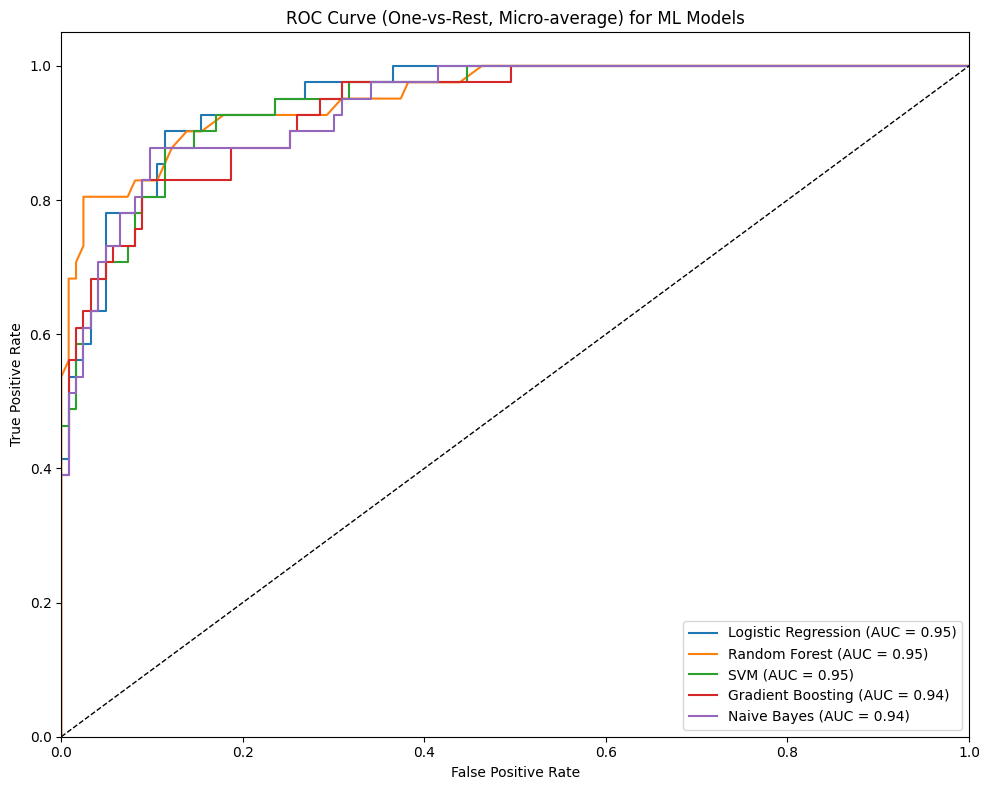

In [24]:
# Plot ROC curves and compute AUC for all ML models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

# List of models and their predicted probabilities
models = [
    ('Logistic Regression', y_pred_proba_lr, y_true_lr),
    ('Random Forest', y_pred_proba_rf, y_true_rf),
    ('SVM', y_pred_proba_svm, y_true_svm),
    ('Gradient Boosting', y_pred_proba_gb, y_true_gb),
    ('Naive Bayes', y_pred_proba_nb, y_true_nb)
 ]

plt.figure(figsize=(10, 8))
for name, y_pred_proba, y_true in models:
    try:
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for ML Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

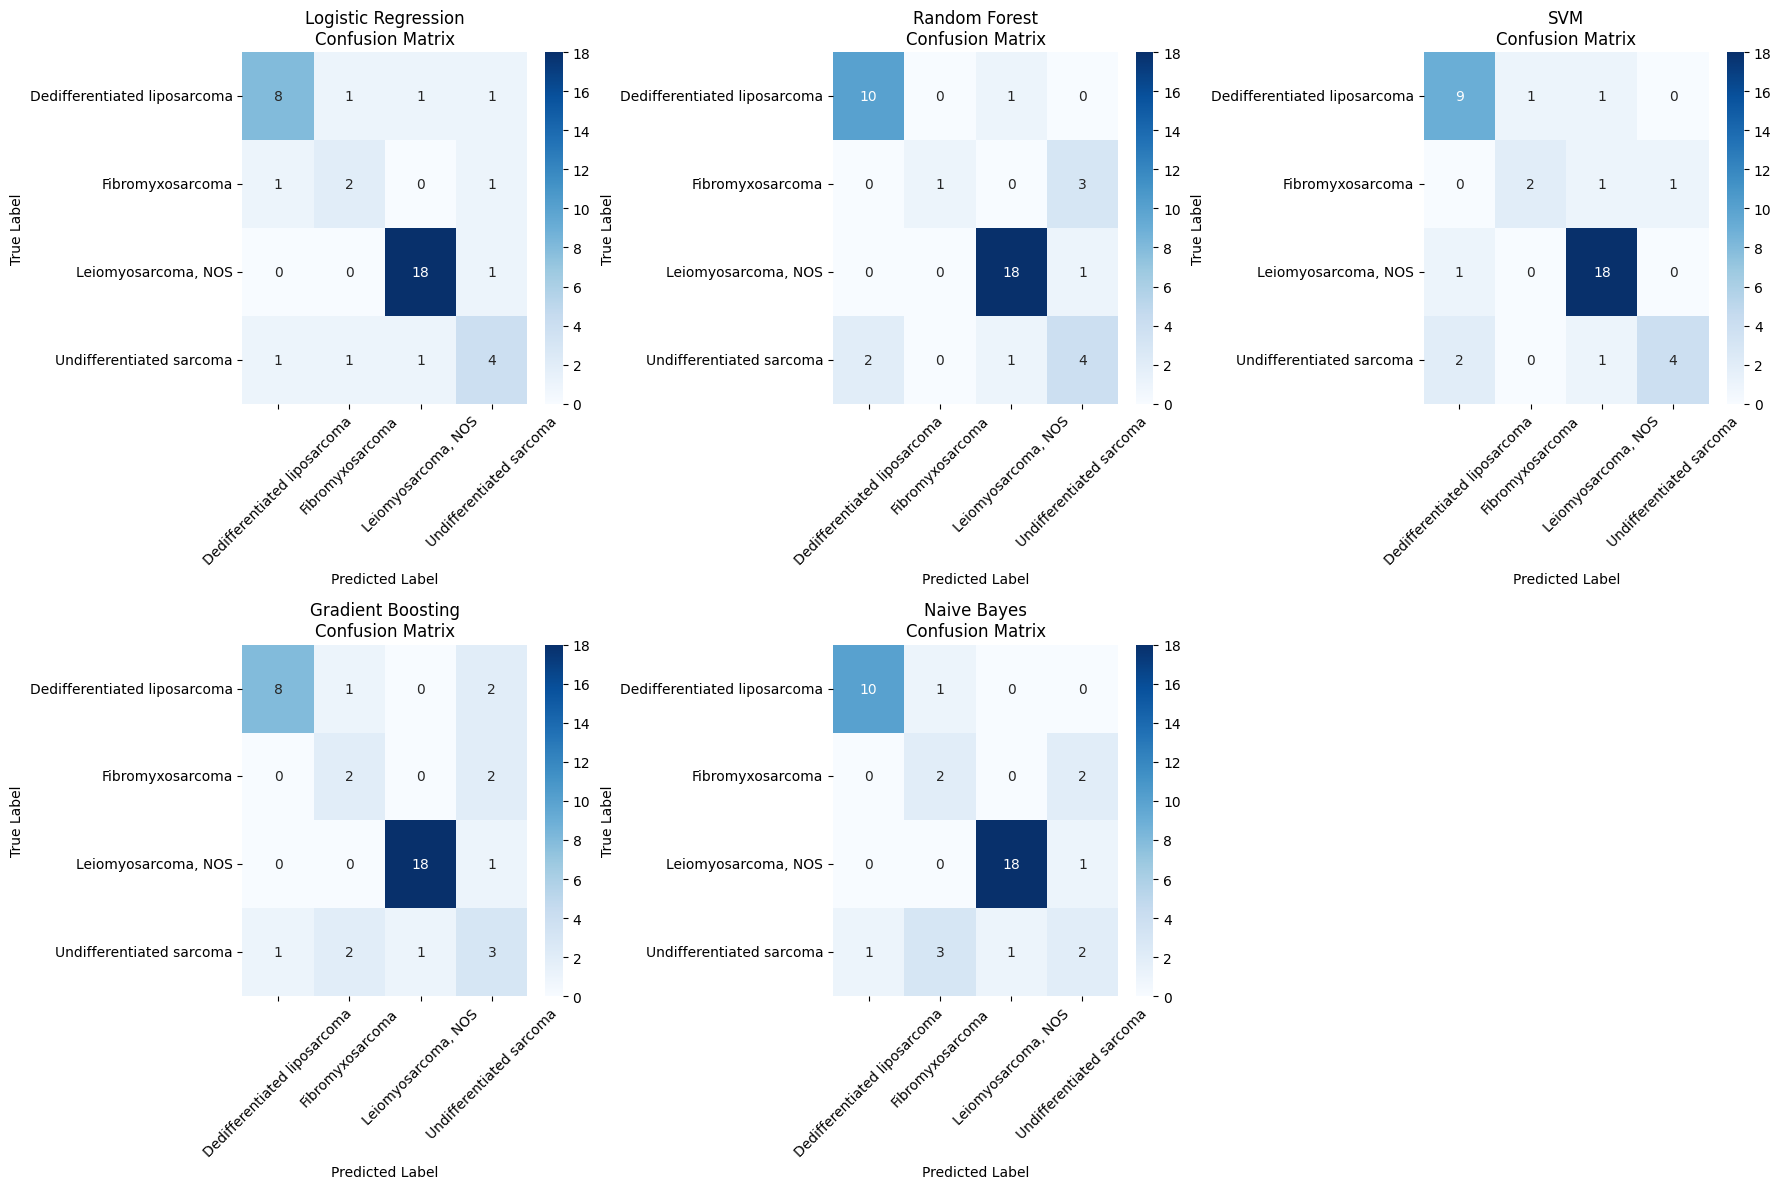


CLASSIFICATION REPORTS FOR ML MODELS

Logistic Regression:
--------------------------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.80      0.73      0.76        11
            Fibromyxosarcoma       0.50      0.50      0.50         4
         Leiomyosarcoma, NOS       0.90      0.95      0.92        19
    Undifferentiated sarcoma       0.57      0.57      0.57         7

                    accuracy                           0.78        41
                   macro avg       0.69      0.69      0.69        41
                weighted avg       0.78      0.78      0.78        41

--------------------------------------------------------------------------------

Random Forest:
--------------------------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.83      0.

In [25]:
# Confusion Matrix and Classification Report for ML Models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names from label encoder
class_names = label_encoder.classes_

# List of ML models with their predictions and true labels
ml_models_cm = [
    ('Logistic Regression', preds_lr, y_true_lr),
    ('Random Forest', preds_rf, y_true_rf),
    ('SVM', preds_svm, y_true_svm),
    ('Gradient Boosting', preds_gb, y_true_gb),
    ('Naive Bayes', preds_nb, y_true_nb)
]

# Create confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, y_pred, y_true) in enumerate(ml_models_cm):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

# Hide the last subplot (we have 5 models, 6 subplots)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Print classification reports
print("\n" + "="*80)
print("CLASSIFICATION REPORTS FOR ML MODELS")
print("="*80)

for name, y_pred, y_true in ml_models_cm:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    print("-" * 80)

In [26]:
# Prepare data (expects `factors` and `subtype_encoded` to exist from earlier cells)
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values

# Split: train+val / test, then carve out validation from train
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [27]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[64], dropout=0.2):
        super(ShallowMLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp_classifier(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, patience=15):
    """Train MLP classifier with early stopping - matches Mixed_integration_mlp methodology"""
    
    # Create data loaders
    from torch.utils.data import DataLoader, TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Shallow MLP - EXACT same architecture as Mixed_integration_mlp
model = ShallowMLP(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow MLP...")
model = train_mlp_classifier(model, X_train_t, y_train_t, X_test_t, y_test_t)

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits_shallow = model(X_test_t)
    preds_shallow = logits_shallow.argmax(dim=1).cpu().numpy()
    y_true_shallow = y_test_t.cpu().numpy()

acc_shallow = accuracy_score(y_true_shallow, preds_shallow)
f1_shallow = f1_score(y_true_shallow, preds_shallow, average='macro')
print(f"\nShallow MLP - Test Accuracy: {acc_shallow:.4f} | Test F1 (macro): {f1_shallow:.4f}")
# End of shallow MLP cell

Training Shallow MLP...
Epoch [50/200], Train Acc: 0.8015, Test Acc: 0.8049
Early stopping at epoch 52

Shallow MLP - Test Accuracy: 0.8049 | Test F1 (macro): 0.6834
Epoch [50/200], Train Acc: 0.8015, Test Acc: 0.8049
Early stopping at epoch 52

Shallow MLP - Test Accuracy: 0.8049 | Test F1 (macro): 0.6834


In [28]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3):
        super(DeepMLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Deep MLP - EXACT same architecture as Mixed_integration_mlp
model = DeepMLP(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("Training Deep MLP...")
model = train_mlp_classifier(model, X_train_t, y_train_t, X_test_t, y_test_t)

model.eval()
with torch.no_grad():
    logits_deep = model(X_test_t)
    preds_deep = logits_deep.argmax(dim=1).cpu().numpy()
    y_true_deep = y_test_t.cpu().numpy()

acc_deep = accuracy_score(y_true_deep, preds_deep)
macrof1_deep = f1_score(y_true_deep, preds_deep, average='macro')
print(f"\nDeep MLP - Test Accuracy: {acc_deep:.4f} | Test F1 (macro): {macrof1_deep:.4f}")

Training Deep MLP...
Early stopping at epoch 40

Deep MLP - Test Accuracy: 0.7805 | Test F1 (macro): 0.6635
Early stopping at epoch 40

Deep MLP - Test Accuracy: 0.7805 | Test F1 (macro): 0.6635


In [29]:
# Native Autoencoder-based Classifiers - EXACT same architecture as Mixed_integration_AE
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

class AEClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(AEClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_ae_classifier(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, patience=15):
    """Train AE-based classifier with early stopping - matches Mixed_integration_AE methodology"""
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

# Train different AE-based classifier architectures
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Shallow AE Classifier - EXACT same architecture as Mixed_integration_AE
shallow_ae = AEClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow AE Classifier...")
shallow_ae = train_ae_classifier(shallow_ae, X_train_t, y_train_t, X_test_t, y_test_t)

# Deep AE Classifier - EXACT same architecture as Mixed_integration_AE
deep_ae = AEClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("Training Deep AE Classifier...")
deep_ae = train_ae_classifier(deep_ae, X_train_t, y_train_t, X_test_t, y_test_t)

def evaluate_ae_classifier(model, X_test, y_test, model_name):
    """Evaluate AE-based classifier and return metrics"""
    import torch.nn.functional as F
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        outputs = model(X_test_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs.data, 1)
        y_pred = predicted.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    c_index = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'C-Index': c_index
    }

# Evaluate all AE-based models
ae_results = []
ae_results.append(evaluate_ae_classifier(shallow_ae, X_test_t.cpu().numpy(), y_test_t.cpu().numpy(), "Shallow AE"))
ae_results.append(evaluate_ae_classifier(deep_ae, X_test_t.cpu().numpy(), y_test_t.cpu().numpy(), "Deep AE"))

# Get logits for later comparison
shallow_ae.eval()
deep_ae.eval()
with torch.no_grad():
    logits_shallow_ae = shallow_ae(X_test_t)
    logits_deep_ae = deep_ae(X_test_t)
    preds_shallow_ae = logits_shallow_ae.argmax(dim=1).cpu().numpy()
    preds_deep_ae = logits_deep_ae.argmax(dim=1).cpu().numpy()
    y_true_ae = y_test_t.cpu().numpy()

# Debug: Check if predictions are actually different
print(f"Shallow AE predictions: {preds_shallow_ae[:10]}")
print(f"Deep AE predictions: {preds_deep_ae[:10]}")
print(f"Predictions are identical: {np.array_equal(preds_shallow_ae, preds_deep_ae)}")
print(f"Number of different predictions: {np.sum(preds_shallow_ae != preds_deep_ae)}")

print("\n" + "="*80)
print("NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS")
print("="*80)
ae_results_df = pd.DataFrame(ae_results)
print(ae_results_df.to_string(index=False))

Training Shallow AE Classifier...
Epoch [50/200], Train Acc: 0.8092, Test Acc: 0.8537
Early stopping at epoch 52
Training Deep AE Classifier...
Epoch [50/200], Train Acc: 0.8092, Test Acc: 0.8537
Early stopping at epoch 52
Training Deep AE Classifier...
Early stopping at epoch 29
Shallow AE predictions: [0 2 2 2 0 3 0 2 3 2]
Deep AE predictions: [2 2 2 2 0 1 0 2 3 2]
Predictions are identical: False
Number of different predictions: 6

NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS
     Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
Shallow AE  0.853659           0.870130           0.853659        0.767686        0.853659    0.797511    0.853659 0.931868
   Deep AE  0.707317           0.620652           0.707317        0.565576        0.707317    0.579670    0.707317 0.924592
Early stopping at epoch 29
Shallow AE predictions: [0 2 2 2 0 3 0 2 3 2]
Deep AE predictions: [2 2 2 2 0 1 0 2 3 2]
Predictions are identical

In [30]:
# Compare results for all NN models: Shallow MLP, Deep MLP, Shallow AE, Deep AE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import torch.nn.functional as F

# Function to calculate C-index for neural network models
def concordance_index_nn(y_true, logits):
    """
    Calculate C-index for neural network models using logits
    """
    try:
        from sklearn.metrics import roc_auc_score
        # Convert logits to probabilities
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

nn_results = []
nn_results.append([
    'Shallow MLP',
    accuracy_score(y_true_shallow, preds_shallow),
    f1_score(y_true_shallow, preds_shallow, average='macro'),
    f1_score(y_true_shallow, preds_shallow, average='micro'),
    precision_score(y_true_shallow, preds_shallow, average='macro', zero_division=0),
    precision_score(y_true_shallow, preds_shallow, average='micro', zero_division=0),
    recall_score(y_true_shallow, preds_shallow, average='macro'),
    recall_score(y_true_shallow, preds_shallow, average='micro'),
    concordance_index_nn(y_true_shallow, logits_shallow)
 ])
nn_results.append([
    'Deep MLP',
    accuracy_score(y_true_deep, preds_deep),
    f1_score(y_true_deep, preds_deep, average='macro'),
    f1_score(y_true_deep, preds_deep, average='micro'),
    precision_score(y_true_deep, preds_deep, average='macro', zero_division=0),
    precision_score(y_true_deep, preds_deep, average='micro', zero_division=0),
    recall_score(y_true_deep, preds_deep, average='macro'),
    recall_score(y_true_deep, preds_deep, average='micro'),
    concordance_index_nn(y_true_deep, logits_deep)
 ])
nn_results.append([
    'Shallow AE',
    accuracy_score(y_true_ae, preds_shallow_ae),
    f1_score(y_true_ae, preds_shallow_ae, average='macro'),
    f1_score(y_true_ae, preds_shallow_ae, average='micro'),
    precision_score(y_true_ae, preds_shallow_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_shallow_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_shallow_ae, average='macro'),
    recall_score(y_true_ae, preds_shallow_ae, average='micro'),
    concordance_index_nn(y_true_ae, logits_shallow_ae)
 ])
nn_results.append([
    'Deep AE',
    accuracy_score(y_true_ae, preds_deep_ae),
    f1_score(y_true_ae, preds_deep_ae, average='macro'),
    f1_score(y_true_ae, preds_deep_ae, average='micro'),
    precision_score(y_true_ae, preds_deep_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_deep_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_deep_ae, average='macro'),
    recall_score(y_true_ae, preds_deep_ae, average='micro'),
    concordance_index_nn(y_true_ae, logits_deep_ae)
 ])

nn_results_df = pd.DataFrame(nn_results, columns=[
    'Model', 'Accuracy', 'F1 Macro', 'F1 Micro', 'Precision Macro', 'Precision Micro', 'Recall Macro', 'Recall Micro', 'C-Index'
 ])

print("\n" + "="*80)
print("NEURAL NETWORK MODEL COMPARISON RESULTS")
print("="*80)
print(nn_results_df.round(3))


NEURAL NETWORK MODEL COMPARISON RESULTS
         Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Shallow MLP     0.805     0.683     0.805            0.733   
1     Deep MLP     0.780     0.663     0.780            0.663   
2   Shallow AE     0.854     0.798     0.854            0.870   
3      Deep AE     0.707     0.580     0.707            0.621   

   Precision Micro  Recall Macro  Recall Micro  C-Index  
0            0.805         0.679         0.805    0.932  
1            0.780         0.669         0.780    0.924  
2            0.854         0.768         0.854    0.932  
3            0.707         0.566         0.707    0.925  


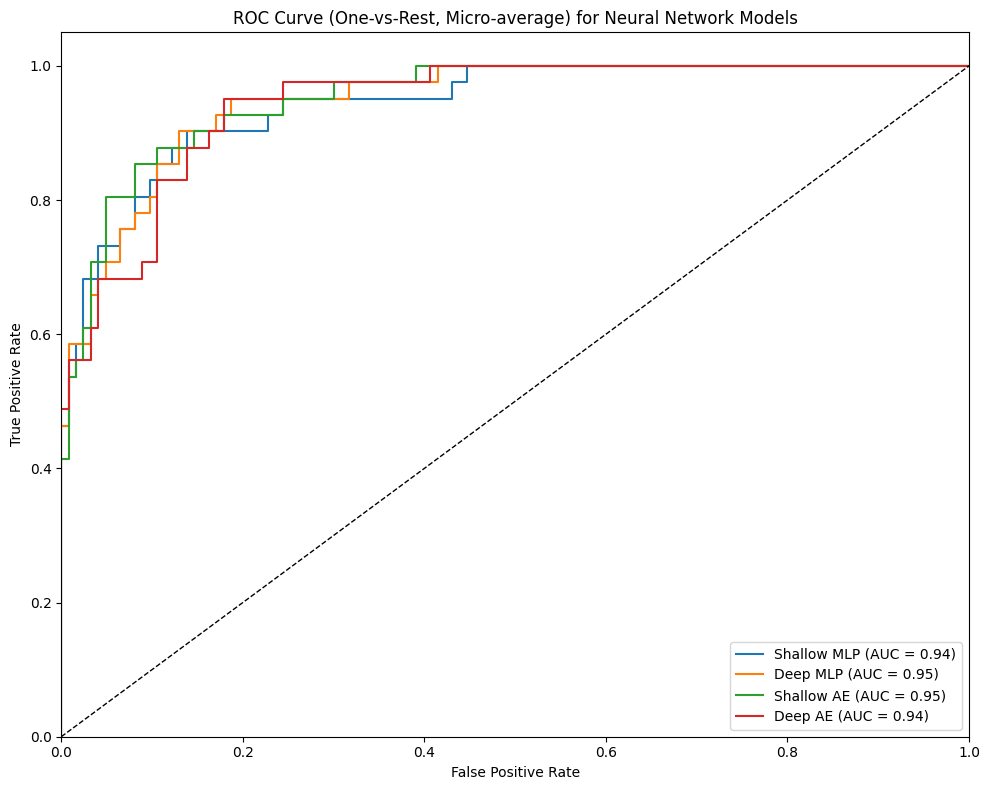

In [31]:
# Plot ROC curves and compute AUC for all NN models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# List of NN models and their logits (before softmax) and true labels
nn_models = [
    ('Shallow MLP', logits_shallow, y_true_shallow),
    ('Deep MLP', logits_deep, y_true_deep),
    ('Shallow AE', logits_shallow_ae, y_true_ae),
    ('Deep AE', logits_deep_ae, y_true_ae)
 ]

plt.figure(figsize=(10, 8))
for name, logits, y_true in nn_models:
    try:
        # Convert logits to probabilities
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for Neural Network Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

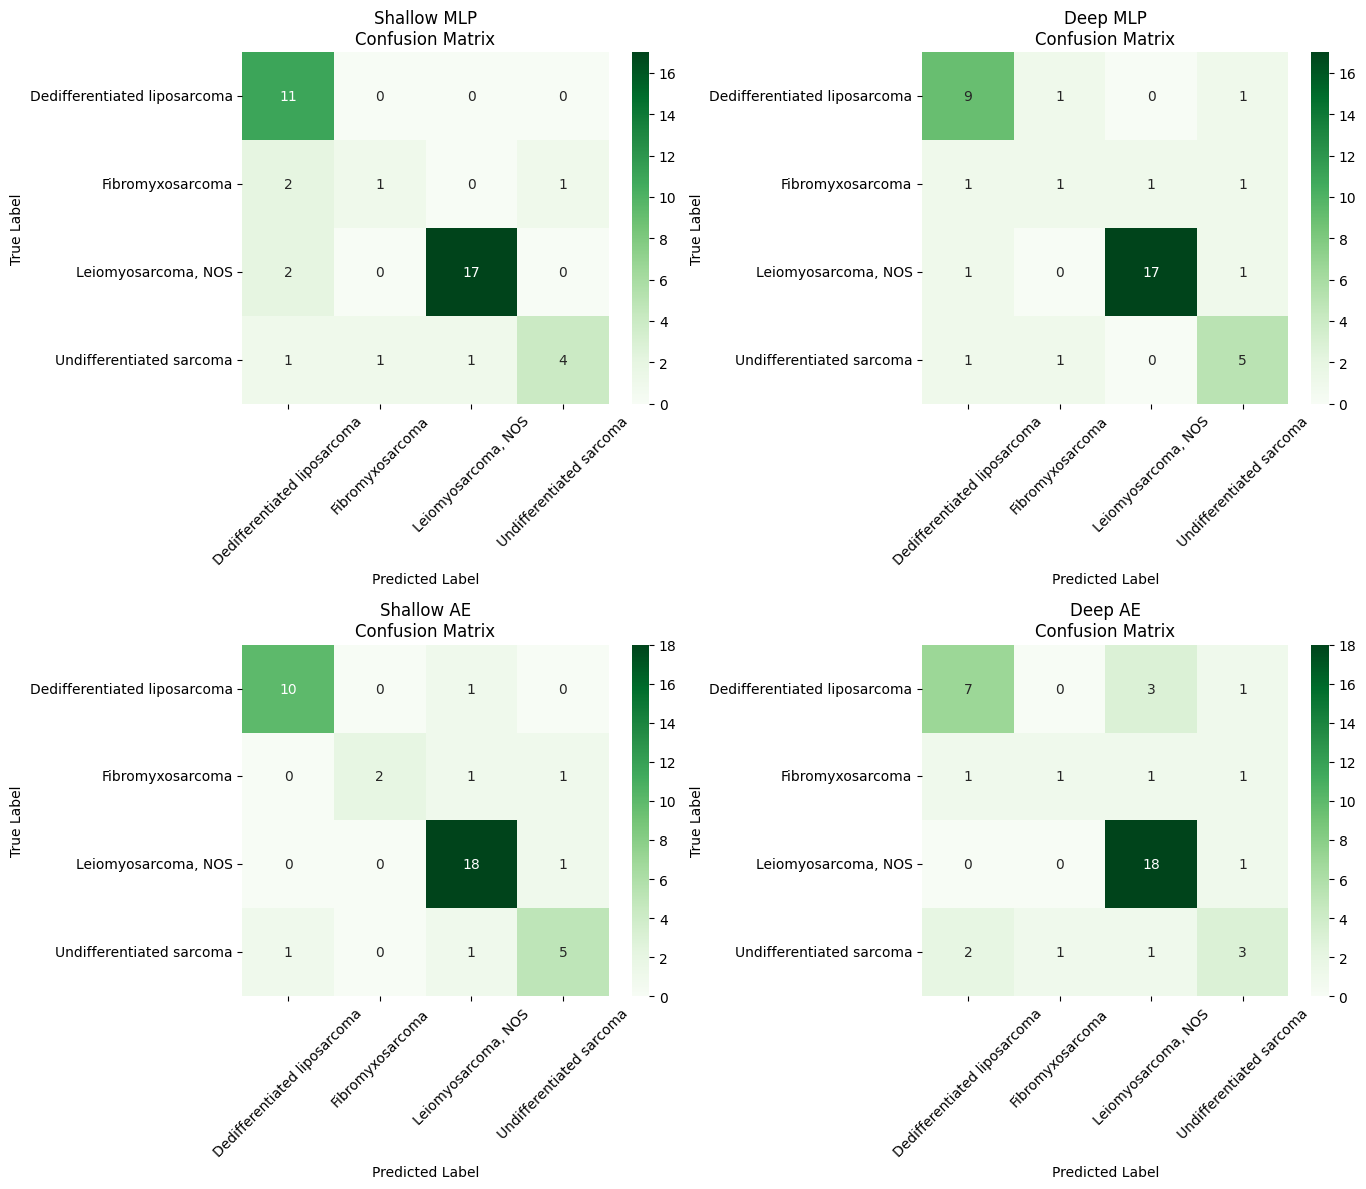


CLASSIFICATION REPORTS FOR NEURAL NETWORK MODELS

Shallow MLP:
--------------------------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.69      1.00      0.81        11
            Fibromyxosarcoma       0.50      0.25      0.33         4
         Leiomyosarcoma, NOS       0.94      0.89      0.92        19
    Undifferentiated sarcoma       0.80      0.57      0.67         7

                    accuracy                           0.80        41
                   macro avg       0.73      0.68      0.68        41
                weighted avg       0.81      0.80      0.79        41

--------------------------------------------------------------------------------

Deep MLP:
--------------------------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.75      0.8

In [32]:
# Confusion Matrix and Classification Report for Neural Network Models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names from label encoder
class_names = label_encoder.classes_

# List of NN models with their predictions and true labels
nn_models_cm = [
    ('Shallow MLP', preds_shallow, y_true_shallow),
    ('Deep MLP', preds_deep, y_true_deep),
    ('Shallow AE', preds_shallow_ae, y_true_ae),
    ('Deep AE', preds_deep_ae, y_true_ae)
]

# Create confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, y_pred, y_true) in enumerate(nn_models_cm):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print classification reports
print("\n" + "="*80)
print("CLASSIFICATION REPORTS FOR NEURAL NETWORK MODELS")
print("="*80)

for name, y_pred, y_true in nn_models_cm:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    print("-" * 80)